### np.reshape

In [6]:
import numpy as np
a = np.array([1,2,3,4])
print(a.shape)
print(a.reshape(4,1))

(4,)
[[1]
 [2]
 [3]
 [4]]


In [14]:
import numpy as np
a = np.arange(8)
print(a)
a = np.arange(8).reshape(2,4)
print(a)
print(np.sum(a, axis=1))
print(np.sum(a, axis=0))

[0 1 2 3 4 5 6 7]
[[0 1 2 3]
 [4 5 6 7]]
[ 6 22]
[ 4  6  8 10]


In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [86]:
class SingleLayer:    
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None              # 가중치
        self.b = None              # 절편
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.w_history = []        # 가중치 기록
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터

    def forpass(self, x): #행렬 곱이어서 전체 sample에 대한 배열이 결과로 출력 됨
        z = np.dot(x, self.w) + self.b        # 선형 출력을 계산합니다.
        return z

    def backprop(self, x, err):
        m = len(x)
        w_grad = np.dot(x.T, err) / m         # 가중치에 대한 그래디언트를 계산합니다. 예전엔 뒤에서 날라온 미분값(error)에 x를 곱한거였음
        b_grad = np.sum(err) / m              # 절편에 대한 그래디언트를 계산합니다.
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))              # 시그모이드 계산 => 변경 없음
        return a
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)                  # 타깃을 열 벡터로 바꿉니다.
        y_val = y_val.reshape(-1, 1)
        m = len(x)                            # 샘플 개수를 저장합니다.
        self.w = np.ones((x.shape[1], 1))     # 가중치를 초기화합니다.
        self.b = 0                            # 절편을 초기화합니다.
        self.w_history.append(self.w.copy())  # 가중치를 기록합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs): #여기가 많이 바뀜 예전코드상 for i in indexes:이런 sample을 뽑는 부분이 없어 짐. 왜냐하면 행렬곱으로 인해...
            z = self.forpass(x)               # 정방향 계산을 수행합니다.
            a = self.activation(z)            # 활성화 함수를 적용합니다.
            err = a - y                   # 오차를 계산합니다.
            # 오차를 역전파하여 그래디언트를 계산합니다.
            w_grad, b_grad = self.backprop(x, err)
            # 그래디언트에서 페널티 항의 미분 값을 더합니다.
            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m
            # 가중치와 절편을 업데이트합니다.
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
            # 가중치를 기록합니다.
            self.w_history.append(self.w.copy())
            # 안전한 로그 계산을 위해 클리핑합니다.
            a = np.clip(a, 1e-10, 1-1e-10)
            # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)
    
    def predict(self, x):
        z = self.forpass(x)      # 정방향 계산을 수행합니다.
        return z > 0             # 스텝 함수를 적용합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == y.reshape(-1, 1))
    
    def reg_loss(self):
        # 가중치에 규제를 적용합니다.
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    
    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
        a = self.activation(z)             # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [87]:
class DualLayer(SingleLayer):
    
    def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
        self.units = units         # 은닉층의 뉴런 개수
        self.w1 = None             # 은닉층의 가중치
        self.b1 = None             # 은닉층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.a1 = None             # 은닉층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터

    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1        # 첫 번째 층의 선형 식을 계산합니다
        self.a1 = self.activation(z1)            # 활성화 함수를 적용합니다
        z2 = np.dot(self.a1, self.w2) + self.b2  # 두 번째 층의 선형 식을 계산합니다.
        return z2

    def backprop(self, x, err):
        m = len(x)       # 샘플 개수
        # 출력층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w2_grad = np.dot(self.a1.T, err) / m # page 146 그림
        b2_grad = np.sum(err) / m  # bias는 아다마르 곱의 편미분 = sum
        # 시그모이드 함수까지 그래디언트를 계산합니다.
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        # 은닉층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad

    def init_weights(self, n_features):
        self.w1 = np.ones((n_features, self.units))  # (특성 개수, 은닉층의 크기) (30,2)
        self.b1 = np.zeros(self.units)               # 은닉층의 크기 (2,)
        self.w2 = np.ones((self.units, 1))           # (은닉층의 크기, 1)
        self.b2 = 0
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)          # 타깃을 열 벡터로 바꿉니다.
        y_val = y_val.reshape(-1, 1)
        m = len(x)                    # 샘플 개수를 저장합니다.
        self.init_weights(x.shape[1]) # 은닉층과 출력층의 가중치를 초기화합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            a = self.training(x, y, m)
            # 안전한 로그 계산을 위해 클리핑합니다.
            a = np.clip(a, 1e-10, 1-1e-10)
            # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)
            
    def training(self, x, y, m):
        z = self.forpass(x)       # 정방향 계산을 수행합니다.
        a = self.activation(z)    # 활성화 함수를 적용합니다.
        err = -(y - a)            # 오차를 계산합니다.
        # 오차를 역전파하여 그래디언트를 계산합니다.
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 그래디언트에서 페널티 항의 미분 값을 뺍니다
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        # 은닉층의 가중치와 절편을 업데이트합니다.
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편을 업데이트합니다.
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
    
    def reg_loss(self):
        # 은닉층과 출력층의 가중치에 규제를 적용합니다.
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

In [88]:
class RandomInitNetwork(DualLayer):
    
    def init_weights(self, n_features):
        np.random.seed(42)
        self.w1 = np.random.normal(0, 1, 
                                   (n_features, self.units))  # (특성 개수, 은닉층의 크기) => 형상 # wait도 random하게 해 줘야 함
        self.b1 = np.zeros(self.units)                        # 은닉층의 크기
        self.w2 = np.random.normal(0, 1, 
                                   (self.units, 1))           # (은닉층의 크기, 1)
        self.b2 = 0

In [89]:
class MinibatchNetwork(RandomInitNetwork):
    
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        super().__init__(units, learning_rate, l1, l2)
        self.batch_size = batch_size     # 배치 크기
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y_val = y_val.reshape(-1, 1)     # 타깃을 열 벡터로 바꿉니다.
        self.init_weights(x.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        np.random.seed(42)
        # epochs만큼 반복합니다.
        for i in range(epochs):
            loss = 0
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            for x_batch, y_batch in self.gen_batch(x, y):
                y_batch = y_batch.reshape(-1, 1) # 타깃을 열 벡터로 바꿉니다.
                m = len(x_batch)                 # 샘플 개수를 저장합니다.
                a = self.training(x_batch, y_batch, m)
                # 안전한 로그 계산을 위해 클리핑합니다.
                a = np.clip(a, 1e-10, 1-1e-10)
                # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
                loss += np.sum(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / len(x))
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size # 미니배치 횟수
        if length % self.batch_size:
            bins += 1                    # 나누어 떨어지지 않을 때
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.

In [90]:
class MultiClassNetwork(MinibatchNetwork):
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        self.units = units         # 은닉층의 뉴런 개수
        self.batch_size = batch_size     # 배치 크기
        self.w1 = None             # 은닉층의 가중치
        self.b1 = None             # 은닉층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.a1 = None             # 은닉층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터

    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1        # 첫 번째 층의 선형 식을 계산합니다
        self.a1 = self.sigmoid(z1)               # 활성화 함수를 적용합니다
        z2 = np.dot(self.a1, self.w2) + self.b2  # 두 번째 층의 선형 식을 계산합니다.
        return z2

    def backprop(self, x, err):
        m = len(x)       # 샘플 개수
        # 출력층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        # 시그모이드 함수까지 그래디언트를 계산합니다.
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        # 은닉층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad
    
    def sigmoid(self, z):
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))              # 시그모이드 계산
        return a
    
    def softmax(self, z):
        # 소프트맥스 함수
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)
 
    def init_weights(self, n_features, n_classes):
        self.w1 = np.random.normal(0, 1, 
                                   (n_features, self.units))  # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)                        # 은닉층의 크기
        self.w2 = np.random.normal(0, 1, 
                                   (self.units, n_classes))   # (은닉층의 크기, 클래스 개수)
        self.b2 = np.zeros(n_classes)
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        np.random.seed(42)
        self.init_weights(x.shape[1], y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            loss = 0
            print('.', end='')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            for x_batch, y_batch in self.gen_batch(x, y):
                a = self.training(x_batch, y_batch)
                # 안전한 로그 계산을 위해 클리핑합니다.
                a = np.clip(a, 1e-10, 1-1e-10)
                # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
                loss += np.sum(-y_batch*np.log(a))
            self.losses.append((loss + self.reg_loss()) / len(x))
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size # 미니배치 횟수
        if length % self.batch_size:
            bins += 1                    # 나누어 떨어지지 않을 때
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
            
    def training(self, x, y):
        m = len(x)                # 샘플 개수를 저장합니다.
        z = self.forpass(x)       # 정방향 계산을 수행합니다.
        a = self.softmax(z)       # 활성화 함수를 적용합니다.
        err = (a - y)            # 오차를 계산합니다.
        # 오차를 역전파하여 그래디언트를 계산합니다.
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 그래디언트에서 페널티 항의 미분 값을 뺍니다
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        # 은닉층의 가중치와 절편을 업데이트합니다.
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편을 업데이트합니다.
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
   
    def predict(self, x):
        z = self.forpass(x)          # 정방향 계산을 수행합니다.
        return np.argmax(z, axis=1)  # 가장 큰 값의 인덱스를 반환합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def reg_loss(self):
        # 은닉층과 출력층의 가중치에 규제를 적용합니다.
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
        a = self.softmax(z)                # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        # 크로스 엔트로피 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss = np.sum(-y_val*np.log(a))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [91]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt


(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [92]:
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


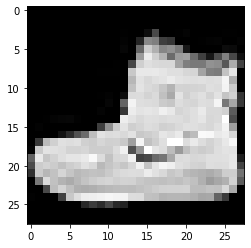

In [93]:
plt.imshow(x_train_all[0], cmap='gray')
plt.show()

In [94]:
print(y_train_all[:100])

[9 0 0 3 0 2 7 2 5 5 0 9 5 5 7 9 1 0 6 4 3 1 4 8 4 3 0 2 4 4 5 3 6 6 0 8 5
 2 1 6 6 7 9 5 9 2 7 3 0 3 3 3 7 2 2 6 6 8 3 3 5 0 5 5 0 2 0 0 4 1 3 1 6 3
 1 4 4 6 1 9 1 3 5 7 9 7 1 7 9 9 9 3 2 9 3 6 4 1 1 8]


In [95]:
class_names = ['티셔츠/윗도리', '바지', '스웨터', '드레스', '코트', 
               '샌들', '셔츠', '스니커즈', '가방', '앵클부츠']
print(class_names[y_train_all[0]])

앵클부츠


### np.bincount 예제

In [96]:
a = np.array([0,4,4,1,2,3,3,3,3,4,5,0])
print(len(a))
print(a.shape[0])
np.bincount(a)

12
12


array([2, 1, 1, 4, 3, 1], dtype=int64)

In [97]:
print(len(y_train_all))
np.bincount(y_train_all)


60000


array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000],
      dtype=int64)

In [98]:

print(len(y_test))
np.bincount(y_test)

10000


array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000],
      dtype=int64)

In [99]:

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [100]:
print(len(y_train))
np.bincount(y_train)

48000


array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800],
      dtype=int64)

In [101]:
print(len(y_val))
np.bincount(y_val)

12000


array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200],
      dtype=int64)

In [102]:
print(len(y_test))
np.bincount(y_test)

10000


array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000],
      dtype=int64)

In [61]:
print(x_train[0])

[[  0   0   0   0   1   1   0   0   0  25  55   0   0   0   0   0   0  43
   24   0   0   0   1   0   0   0   0   0]
 [  0   0   0   1   1   1   0  25 147 189 181  96  51  49  55  37  76 217
  172 125  20   0   2   1   0   0   0   0]
 [  0   0   0   1   3   0  82 206 202 190 178 188 239 152  99 199 201 162
  176 192 185  71   0   2   0   0   0   0]
 [  0   0   0   1   0   0 202 196 181 188 183 169 179 160 107 198 166 167
  178 170 183 166   0   0   1   0   0   0]
 [  0   0   0   1   0  48 216 184 185 185 190 175 164 188 198 188 157 183
  176 171 167 175  26   0   2   0   0   0]
 [  0   0   0   0   0  90 224 183 185 184 183 190 164 169 193 158 170 174
  176 175 165 180  62   0   0   0   0   0]
 [  0   0   0   0   0 123 228 184 180 183 178 183 172 172 172 161 179 170
  174 175 165 181 106   0   0   0   0   0]
 [  0   0   0   0   0 156 229 188 175 178 175 175 190 157 157 180 169 169
  172 171 161 179 143   0   0   0   0   0]
 [  0   0   0   0   0 181 228 190 174 174 176 175 197 167 167 18

In [103]:
#scale 맞춤
x_train = x_train / 255
x_val = x_val / 255
print(x_train[0])

[[0.         0.         0.         0.         0.00392157 0.00392157
  0.         0.         0.         0.09803922 0.21568627 0.
  0.         0.         0.         0.         0.         0.16862745
  0.09411765 0.         0.         0.         0.00392157 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.00392157 0.00392157 0.00392157
  0.         0.09803922 0.57647059 0.74117647 0.70980392 0.37647059
  0.2        0.19215686 0.21568627 0.14509804 0.29803922 0.85098039
  0.6745098  0.49019608 0.07843137 0.         0.00784314 0.00392157
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.00392157 0.01176471 0.
  0.32156863 0.80784314 0.79215686 0.74509804 0.69803922 0.7372549
  0.9372549  0.59607843 0.38823529 0.78039216 0.78823529 0.63529412
  0.69019608 0.75294118 0.7254902  0.27843137 0.         0.00784314
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.00392157 0.         0.
  0.7921

In [104]:
print(x_train.shape)

(48000, 28, 28)


In [105]:
#3차원 배열을 2차원 배열로 reshape 해야 함
x_train = x_train.reshape(-1, 784) # -은 48000 기존값을 이용하려고 이렇게 함
x_val = x_val.reshape(-1, 784)
print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


In [69]:
y_train[0]

6

In [106]:
tf.keras.utils.to_categorical([0, 1, 3]) # 원 핫 인코딩 0, 1, 3 자리만 켜 지도록 배열이 2차원 배열로 바뀜

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [107]:

y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)
print(y_train_encoded.shape, y_val_encoded.shape)

(48000, 10) (12000, 10)


In [108]:

print(y_train[0], y_train_encoded[0])

6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


........................................

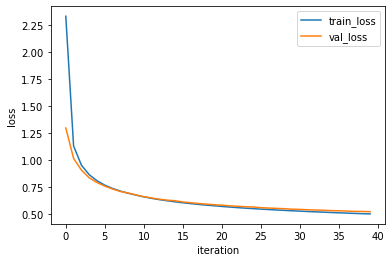

In [109]:
fc = MultiClassNetwork(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded, 
       x_val=x_val, y_val=y_val_encoded, epochs=40)

lt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

### 다중분류 케라스로 구현하기 

In [111]:
import numpy as np
x = np.array([2, 8, 3, 7, 1, 2, 0, 4, 5])
w = np.array([2, 1, 5, 3])

In [113]:
w_r = np.flip(w)
print(w_r)

[3 5 1 2]


In [115]:
for i in range(6):
    print(np.dot(x[i:i+4], w_r.reshape(-1,1))) # reshape하는건 세우려고 하는 것임

[63]
[48]
[49]
[28]
[21]
[20]


In [119]:
from scipy.signal import convolve
convolve(x, w, mode='valid')

array([63, 48, 49, 28, 21, 20])

In [121]:
from scipy.signal import correlate

In [123]:

correlate(x, w, mode='valid')

array([48, 57, 24, 25, 16, 39])

In [125]:

correlate(x, w, mode='full')

array([ 6, 34, 51, 48, 57, 24, 25, 16, 39, 29, 13, 10])

In [126]:

correlate(x, w, mode='same')

array([34, 51, 48, 57, 24, 25, 16, 39, 29])

In [128]:
x = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
w = np.array([[2, 0], [0, 0]])
from scipy.signal import correlate2d
correlate2d(x, w, mode='valid')

array([[ 2,  4],
       [ 8, 10]])

### 합성곱 연산

2.4.1
(1, 3, 3, 1)


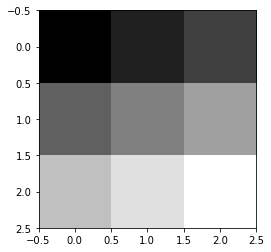

In [183]:
import tensorflow as tf
import numpy as np
import keras
from keras.layers import *
import matplotlib.pyplot as plt
print( tf.__version__ )
image = tf.constant([[[[1],[2],[3]],
                      [[4],[5],[6]],
                      [[7],[8],[9]]]], dtype=np.float32)
print(image.shape)
plt.imshow(image.numpy().reshape(3,3), cmap='gray') #실제 색상이 아니라 상대적인 diff를 색으로  보여준다

In [184]:
weight = np.array([[[[1.]],[[1.]]],[[[1.]],[[1.]]]]) # filter 4차원이지만 2x2처럼 보임
print("weight.shape", weight.shape)


weight.shape (2, 2, 1, 1)


conv2d.shape (1, 2, 2, 1)
tf.Tensor(
[[[[12.]
   [16.]]

  [[24.]
   [28.]]]], shape=(1, 2, 2, 1), dtype=float32)
[[[[12.]
   [16.]]

  [[24.]
   [28.]]]]
[[12. 16.]
 [24. 28.]]


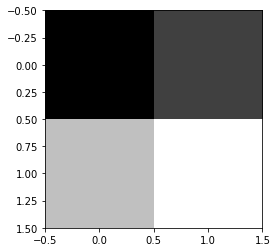

In [185]:
weight_init = tf.constant_initializer(weight) # 1차원으로 펴지는 느낌
conv2d = tf.keras.layers.Conv2D(filters=1, kernel_size=2, padding='valid', kernel_initializer=weight_init)(image)
print("conv2d.shape", conv2d.shape)
print(conv2d)
print(conv2d.numpy())
print(conv2d.numpy().reshape(2,2))
plt.imshow(conv2d.numpy().reshape(2,2), cmap='gray')

In [163]:
image = tf.constant([[[[1],[2],[3]],
                      [[4],[5],[6]],
                      [[7],[8],[9]]]], dtype=np.float32)
print(image.shape)

(1, 3, 3, 1)


In [160]:
weight = np.array([[[[1.,10.,-1.]],[[1.,10.,-1.]]],[[[1.,10.,-1.]],[[1.,10.,-1.]]]])
print(weight.shape)

(2, 2, 1, 3)


conv2d.shape (1, 2, 2, 3)
tf.Tensor(
[[[[ 12. 120. -12.]
   [ 16. 160. -16.]]

  [[ 24. 240. -24.]
   [ 28. 280. -28.]]]], shape=(1, 2, 2, 3), dtype=float32)
[[12. 16.]
 [24. 28.]]
[[120. 160.]
 [240. 280.]]
[[-12. -16.]
 [-24. -28.]]


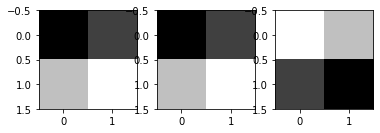

In [173]:
weight_init = tf.constant_initializer(weight) # 1차원으로 펴지는 느낌
conv2d = tf.keras.layers.Conv2D(filters=3, kernel_size=2, padding='valid', kernel_initializer=weight_init)(image)
print("conv2d.shape", conv2d.shape)
print(conv2d)

# print(conv2d.numpy())
# plt.imshow(conv2d.numpy().reshape(2,6), cmap='gray')


feature_maps = np.swapaxes(conv2d, 0, 3) # (1, 2, 2, 3) -> (3, 2, 2, 1) 으로 바뀌게 된다 축교환 하게 되면 for loop으로 뽑아낼 수 있다
for i, feature_map in enumerate(feature_maps):
    print(feature_map.reshape(2,2))
    plt.subplot(1,3,i+1), plt.imshow(feature_map.reshape(2,2), cmap='gray')
plt.show()

conv2d.shape (1, 3, 3, 3)
tf.Tensor(
[[[[ 12. 120. -12.]
   [ 16. 160. -16.]
   [  9.  90.  -9.]]

  [[ 24. 240. -24.]
   [ 28. 280. -28.]
   [ 15. 150. -15.]]

  [[ 15. 150. -15.]
   [ 17. 170. -17.]
   [  9.  90.  -9.]]]], shape=(1, 3, 3, 3), dtype=float32)
[[12. 16.  9.]
 [24. 28. 15.]
 [15. 17.  9.]]
[[120. 160.  90.]
 [240. 280. 150.]
 [150. 170.  90.]]
[[-12. -16.  -9.]
 [-24. -28. -15.]
 [-15. -17.  -9.]]


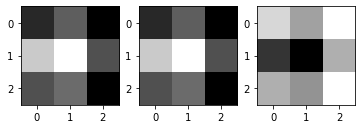

In [175]:
weight_init = tf.constant_initializer(weight) # 1차원으로 펴지는 느낌
conv2d = tf.keras.layers.Conv2D(filters=3, kernel_size=2, padding='same', kernel_initializer=weight_init)(image)
print("conv2d.shape", conv2d.shape)
print(conv2d)

feature_maps = np.swapaxes(conv2d, 0, 3)
for i, feature_map in enumerate(feature_maps):
    print(feature_map.reshape(3,3))
    plt.subplot(1,3,i+1), plt.imshow(feature_map.reshape(3,3), cmap='gray')
plt.show()

In [190]:
image = tf.constant(  [[ 
                         [[1,0,1],[1,1,1],[1,1,1],[0,0,1],[0,1,0]], 
                         [[0,0,1],[1,1,1],[1,1,1],[1,1,1],[0,0,0]], 
                         [[0,0,0],[0,0,0],[1,1,0],[1,1,1],[1,0,1]], 
                         [[0,0,0],[0,0,1],[1,1,1],[1,1,1],[0,1,0]], 
                         [[0,1,0],[1,1,1],[1,1,1],[0,0,0],[0,0,0]] 
                      ]],     dtype=np.float32)

maps = np.swapaxes(image, 0, 3)
for i, map in enumerate(maps):
    print(map.reshape(5,5))


[[1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1.]
 [0. 0. 1. 1. 0.]
 [0. 1. 1. 0. 0.]]
[[0. 1. 1. 0. 1.]
 [0. 1. 1. 1. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 1. 1. 1.]
 [1. 1. 1. 0. 0.]]
[[1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 0.]
 [0. 0. 0. 1. 1.]
 [0. 1. 1. 1. 0.]
 [0. 1. 1. 0. 0.]]


In [191]:
weight = np.array( [ 
                     [[[1],[0],[-1]], [[0],[-1],[0]], [[1],[0],[0]]],
                     [[[0],[-1],[0]], [[1],[1],[1]], [[0],[-1],[0]]],
                     [[[1],[1],[0]], [[0],[-1],[0]], [[1],[0],[-1]]]
                   ] )
# maps = np.swapaxes(weight, 1, 2)
# maps = np.swapaxes(maps, 0, 1)
maps = np.transpose(weight, (2,0,1,3)) # 위에 두 줄을 transpose 함수로 변경 가능

for i, map in enumerate(maps):
    print(map.reshape(3,3))



[[1 0 1]
 [0 1 0]
 [1 0 1]]
[[ 0 -1  0]
 [-1  1 -1]
 [ 1 -1  0]]
[[-1  0  0]
 [ 0  1  0]
 [ 0  0 -1]]


In [192]:
weight_init = tf.constant_initializer(weight)
conv2d = tf.keras.layers.Conv2D(filters=1, kernel_size=3, padding='valid', kernel_initializer=weight_init)(image)
print("conv2d.shape", conv2d.shape)
feature_maps = np.swapaxes(conv2d, 0, 3)
for i, feature_map in enumerate(feature_maps):
    print(feature_map.reshape(3,3))

conv2d.shape (1, 3, 3, 1)
[[ 3. -1.  3.]
 [-2.  0.  2.]
 [ 1.  3.  4.]]


In [194]:
weight = np.array( [ 
                     [[[1,1],[0,1],[-1,-1]], [[0,0],[-1,0],[0,0]], [[1,1],[0,1],[0,0]]],
                     [[[0,0],[-1,0],[0,0]], [[1,1],[1,1],[1,1]], [[0,0],[-1,0],[0,0]]],
                     [[[1,1],[1,1],[0,0]], [[0,0],[-1,0],[0,0]], [[1,1],[0,1],[-1,-1]]]
                   ] )
maps = np.swapaxes(weight, 1, 2)
maps = np.swapaxes(maps, 0, 1)

for map in maps:
    map = np.swapaxes(map, 1, 2)
    map = np.swapaxes(map, 0, 1)
    for filter in map:
       print(filter)


[[1 0 1]
 [0 1 0]
 [1 0 1]]
[[1 0 1]
 [0 1 0]
 [1 0 1]]
[[ 0 -1  0]
 [-1  1 -1]
 [ 1 -1  0]]
[[1 0 1]
 [0 1 0]
 [1 0 1]]
[[-1  0  0]
 [ 0  1  0]
 [ 0  0 -1]]
[[-1  0  0]
 [ 0  1  0]
 [ 0  0 -1]]


In [198]:
weight = np.array( [ 
                     [[[1,1],[0,1],[-1,-1]], [[0,0],[-1,0],[0,0]], [[1,1],[0,1],[0,0]]],
                     [[[0,0],[-1,0],[0,0]], [[1,1],[1,1],[1,1]], [[0,0],[-1,0],[0,0]]],
                     [[[1,1],[1,1],[0,0]], [[0,0],[-1,0],[0,0]], [[1,1],[0,1],[-1,-1]]]
                   ] )

maps = np.transpose(weight, (2, 3, 0, 1))

for map in maps:
    for filter in map:
        print(filter)

[[1 0 1]
 [0 1 0]
 [1 0 1]]
[[1 0 1]
 [0 1 0]
 [1 0 1]]
[[ 0 -1  0]
 [-1  1 -1]
 [ 1 -1  0]]
[[1 0 1]
 [0 1 0]
 [1 0 1]]
[[-1  0  0]
 [ 0  1  0]
 [ 0  0 -1]]
[[-1  0  0]
 [ 0  1  0]
 [ 0  0 -1]]


### 고차원 텐서 연습 

In [204]:
a = np.arange(12).reshape(3,2,2) #3x2x2
print(a.shape)
print(a)

(3, 2, 2)
[[[ 0  1]
  [ 2  3]]

 [[ 4  5]
  [ 6  7]]

 [[ 8  9]
  [10 11]]]


In [208]:
a = np.arange(12).reshape(3,2,2) #3x2x2
print(a.shape)
print(a)
b = np.swapaxes(a, 0, 1)
print(b)

(3, 2, 2)
[[[ 0  1]
  [ 2  3]]

 [[ 4  5]
  [ 6  7]]

 [[ 8  9]
  [10 11]]]
[[[ 0  1]
  [ 4  5]
  [ 8  9]]

 [[ 2  3]
  [ 6  7]
  [10 11]]]


In [210]:
a = np.arange(12).reshape(3,2,2) #3x2x2
print(a.shape)
print(a)
b = np.swapaxes(a, 1, 2)
print(b)

(3, 2, 2)
[[[ 0  1]
  [ 2  3]]

 [[ 4  5]
  [ 6  7]]

 [[ 8  9]
  [10 11]]]
[[[ 0  2]
  [ 1  3]]

 [[ 4  6]
  [ 5  7]]

 [[ 8 10]
  [ 9 11]]]


In [211]:
a = np.arange(12).reshape(3,2,2) #3x2x2
print(a.shape)
print(a)
b = np.swapaxes(a, 0, 2)
print(b)

(3, 2, 2)
[[[ 0  1]
  [ 2  3]]

 [[ 4  5]
  [ 6  7]]

 [[ 8  9]
  [10 11]]]
[[[ 0  4  8]
  [ 2  6 10]]

 [[ 1  5  9]
  [ 3  7 11]]]


In [213]:
a = np.arange(16).reshape(2,2,2,2) #2x2x2x2
print(a.shape)
print(a)
print("------------")
b = np.swapaxes(a, 0, 3)
print(b)

(2, 2, 2, 2)
[[[[ 0  1]
   [ 2  3]]

  [[ 4  5]
   [ 6  7]]]


 [[[ 8  9]
   [10 11]]

  [[12 13]
   [14 15]]]]
------------
[[[[ 0  8]
   [ 2 10]]

  [[ 4 12]
   [ 6 14]]]


 [[[ 1  9]
   [ 3 11]]

  [[ 5 13]
   [ 7 15]]]]


In [215]:
image = tf.constant([ [ [ [4], [3] ], [[2],[1]] ] ], dtype=np.float32)
pool = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=1, padding='valid')(image)
print(pool.shape)
print(pool.numpy())



(1, 1, 1, 1)
[[[[4.]]]]


(60000, 28, 28)


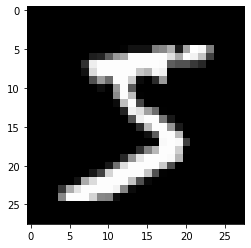

In [218]:
mnist = keras.datasets.mnist
class_names = ['0','1','2','3','4','5','6','7','8','9']

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.

print(train_images.shape)
img = train_images[0]
plt.imshow( img, cmap='gray')
plt.show()


conv2d.shape (1, 14, 14, 5)


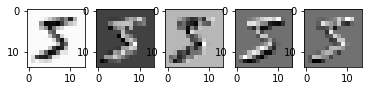

conv2d.shape (1, 28, 28, 5)


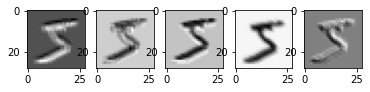

conv2d.shape (1, 26, 26, 5)


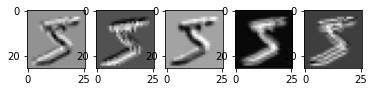

In [224]:
img = train_images[0]
img = img.reshape(-1,28,28,1)
img = tf.convert_to_tensor(img)

weight_init = keras.initializers.RandomNormal(stddev=0.01) #weight가 random하게 생김
conv2d = keras.layers.Conv2D(filters=5, kernel_size=3, padding='same', 
                             strides=(2,2), kernel_initializer=weight_init)(img)
print("conv2d.shape", conv2d.shape)
feature_maps = np.swapaxes(conv2d, 0, 3)
for i, feature_map in enumerate(feature_maps):
    plt.subplot(1,5,i+1), plt.imshow(feature_map.reshape(14,14), cmap='gray')
plt.show()

conv2d = keras.layers.Conv2D(filters=5, kernel_size=3, padding='same', 
                             strides=(1,1), kernel_initializer=weight_init)(img)
print("conv2d.shape", conv2d.shape)
feature_maps = np.swapaxes(conv2d, 0, 3)
for i, feature_map in enumerate(feature_maps):
    plt.subplot(1,5,i+1), plt.imshow(feature_map.reshape(28,28), cmap='gray')
plt.show()

conv2d = keras.layers.Conv2D(filters=5, kernel_size=3, padding='valid', 
                             strides=(1,1), kernel_initializer=weight_init)(img)
print("conv2d.shape", conv2d.shape)
feature_maps = np.swapaxes(conv2d, 0, 3)
for i, feature_map in enumerate(feature_maps):
    plt.subplot(1,5,i+1), plt.imshow(feature_map.reshape(26,26), cmap='gray') #28-3+1
plt.show()

(1, 13, 13, 5)


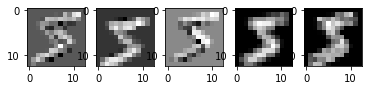

In [226]:
pool = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same')(conv2d)
print(pool.shape)
feature_maps = np.swapaxes(pool, 0, 3)
for i, feature_map in enumerate(feature_maps):
    plt.subplot(1,5,i+1), plt.imshow(feature_map.reshape(13,13), cmap='gray')
plt.show()